In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import emcee

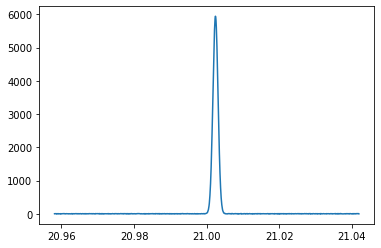

In [2]:
file_data = pd.read_csv("spectrum_d_0.69_kpc.txt", sep = " ")
plt.plot( file_data["wavelngth (cm)"], file_data["brightness"])
plt.show()

In [3]:
def mygaussian(x, *p):
    u,s,A,b = p
    return A* np.exp(-(x-u)**2/(2.0*(s**2))) + b

In [4]:
def model(theta, x):
    return mygaussian(x, theta[0], theta[1], theta[2], theta[3])

In [5]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y-model(theta, x))/yerr)**2)

In [6]:
def lnprior(theta):
    u,s,A,b= theta
    if(abs(u-21)<=0.04 and 0<=s<=0.01 and 5500<=A<=6500 and -100<=b<=100):
        return 0.0;
    return -np.inf

In [7]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if np.isfinite(lp):
        return lp + lnlike(theta, x,y, yerr)
    return -np.inf
    

In [8]:
y = np.array(file_data["brightness"])
x = np.array(file_data["wavelngth (cm)"])
yerr = 0.05*(y)
data = (x,y,yerr)

In [9]:
nwalkers = 128
niter = 500

In [78]:
initial = np.array([21, 0.005, 6000, 0])
ndim = len(initial)


#this scale thing is me experimenting by making walker deviations proportinal to the initial guess
scale = 10**np.floor(np.log10(initial + 1e-1)  )

p0 = [(initial + 1e-5 * scale* np.random.randn(ndim))   for i in range(nwalkers) ]


In [79]:
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = data)
    
    
    #this is to start from a state i made up, and so some iterations to end up at a high probability state
    #essentially we throw away the first few iterations of mcmc because they are not useful
    #now we take the current state and make that our new state
    print("Running burn in ")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    
    #the actual mcmc
    print("Running production")
    pos, prob, state = sampler.run_mcmc(p0, niter)
    return sampler, pos, prob, state

In [80]:
sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, data);

Running burn in 


Running production


In [81]:
samples = sampler.flatchain

In [82]:
def plotter(samples, x,y, num = nwalkers):
    plt.scatter(x,y, color = 'b')
    #taking 100 random walkers
    for theta in samples[np.random.randint(len(samples), size = num)]:
        plt.plot(x, model(theta, x), color = 'r', alpha = 1)
        
    plt.show()

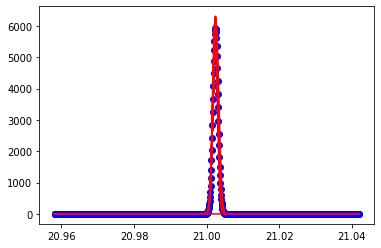

In [83]:
plotter(samples, x, y)

In [84]:
def bestplotter(samples, x,y):
    plt.scatter(x,y)
    best = samples[np.argmax(sampler.flatlnprobability)]
    print("mean",best[0], "\nsd", best[1], "\namp", best[2], "\nshift", best[3])
    bestmodel = model(best, x)
    plt.plot(x,bestmodel, color = 'r')
    return best

mean 21.00244527426938 
sd 0.0007256468844502481 
amp 5500.552533083996 
shift 0.03967325381097738


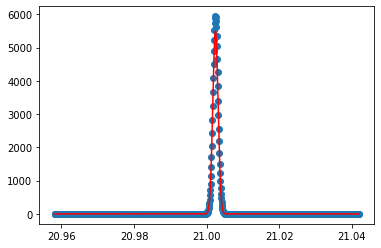

In [85]:
best = bestplotter(samples, x,y)

-------------------------------------------------------


In [86]:
import scipy.optimize

In [87]:
opt = scipy.optimize.curve_fit(mygaussian,x,y,p0=initial)
print("mean",opt[0][0], "\nsd", opt[0][1], "\namp", opt[0][2], "\nshift", opt[0][3])

mean 21.002451787048912 
sd 0.0007004533361411082 
amp 5938.910949510307 
shift 5.371944784400947


In [88]:
#relative error between mcmc and optimize
print((best- opt[0])/opt[0])

[-3.10096154e-07  3.59674899e-02 -7.38112459e-02 -9.92614732e-01]


------------------------------------------------------------------------------------------------------------------------------------

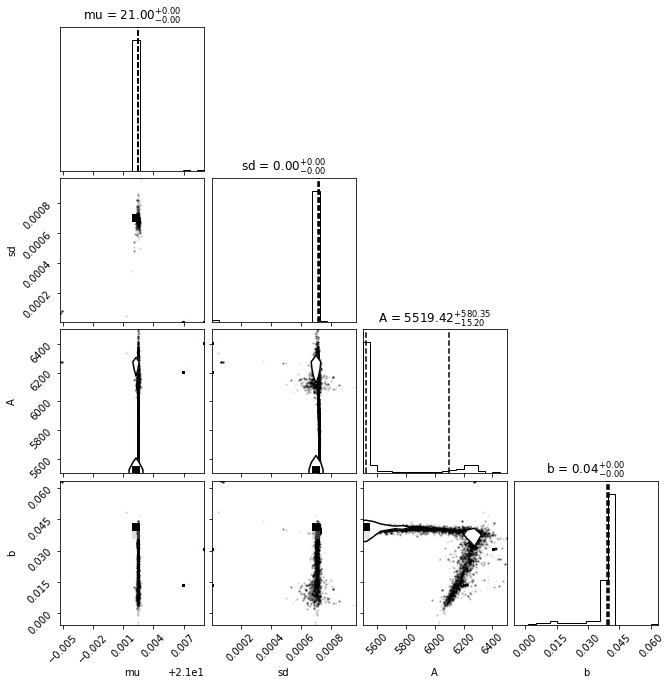

In [89]:
import corner
labels = ['mu', 'sd', 'A', 'b']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])